<a href="https://colab.research.google.com/github/zjc664656505/BQ_PROJECT/blob/main/BQ_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Load data from Google Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

#Mount to your google drive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [2]:
#define method for feature selection
def feature_selection(dataframe, feature_list):
  '''
    This is a method which returns the new dataframe in which the features are selected
  '''
  return dataframe[feature_list]

In [3]:
data = pd.read_csv("/content/drive/MyDrive/BrightQuery_Project/meta-model/new_merged_meta_data.csv")

In [4]:
primary_key = ['bq_id', 'bq_year']
other_group_features = ['bq_sector_name', 'bq_business_code', 'bq_company_address1_state']

In [5]:
# get the company info
categorical_variable = feature_selection(data, ['bq_id']+other_group_features)
company_info = categorical_variable.drop_duplicates(subset=['bq_id'])
# Convert categorical variable into dummy/indicator variables.
company_info = pd.get_dummies(data=company_info)

In [6]:
company_info

,bq_id,bq_business_code,bq_sector_name_Accommodation and Food Services,bq_sector_name_Administrative and Support and Waste Management and Remediation Services,"bq_sector_name_Agriculture, Forestry, Fishing and Hunting","bq_sector_name_Arts, Entertainment, and Recreation",bq_sector_name_Construction,bq_sector_name_Educational Services,bq_sector_name_Finance and Insurance,bq_sector_name_Health Care and Social Assistance,bq_sector_name_Information,bq_sector_name_Management of Companies (Holding Companies),bq_sector_name_Manufacturing,bq_sector_name_Mining,bq_sector_name_Other Services,"bq_sector_name_Professional, Scientific, and Technical Services",bq_sector_name_Real Estate and Rental and Leasing,bq_sector_name_Retail Trade,bq_sector_name_Transportation and Warehousing,bq_sector_name_Utilities,bq_sector_name_Wholesale Trade,bq_company_address1_state_AK,bq_company_address1_state_AL,bq_company_address1_state_AR,bq_company_address1_state_AZ,bq_company_address1_state_CA,bq_company_address1_state_CO,bq_company_address1_state_CT,bq_company_address1_state_DC,bq_company_address1_state_DE,bq_company_address1_state_FL,bq_company_address1_state_GA,bq_company_address1_state_HI,bq_company_address1_state_IA,bq_company_address1_state_ID,bq_company_address1_state_IL,bq_company_address1_state_IN,bq_company_address1_state_KS,bq_company_address1_state_KY,bq_company_address1_state_LA,bq_company_address1_state_MA,bq_company_address1_state_MD,bq_company_address1_state_ME,bq_company_address1_state_MI,bq_company_address1_state_MN,bq_company_address1_state_MO,bq_company_address1_state_MS,bq_company_address1_state_MT,bq_company_address1_state_NC,bq_company_address1_state_ND,bq_company_address1_state_NE,bq_company_address1_state_NH,bq_company_address1_state_NJ,bq_company_address1_state_NM,bq_company_address1_state_NV,bq_company_address1_state_NY,bq_company_address1_state_OH,bq_company_address1_state_OK,bq_company_address1_state_OR,bq_company_address1_state_PA,bq_company_address1_state_PR,bq_company_address1_state_RI,bq_company_address1_state_SC,bq_company_address1_state_SD,bq_company_address1_state_TN,bq_company_address1_state_TX,bq_company_address1_state_UT,bq_company_address1_state_VA,bq_company_address1_state_VI,bq_company_address1_state_VT,bq_company_address1_state_WA,bq_company_address1_state_WI,bq_company_address1_state_WV
0,412416919,221210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,136315656,522110,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,666958061,722511,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,105749915,522110,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,218284269,522110,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16057,484886126,334200,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16421,500295400,333100,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17291,732838577,541700,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18385,230033736,561450,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [7]:
# define method for Relative Absolute Error (RAE)
def RAE(y_true, y_pred):
  true = np.array(y_true)
  pred = np.array(y_pred)
  numerator =  np.sum(np.abs(true - pred))
  denominator = np.sum(np.abs(true - np.mean(true)))
  return numerator/denominator

# define method for Mean Absolute Error (MAE)
def MAE(y_true, y_pred):
  return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

## 2 Linear Regression Assumptions Check

### 2.1 Response: 2020 Net Income vs. Predictor: 2019 Net Income

In [8]:
net_income_2020 = data[data.bq_year == 2020][['bq_id', 'bq_net_income']]
net_income_2020.columns=['bq_id', 'bq_net_income_2020']
net_income_2019 = data[data.bq_year == 2019][['bq_id', 'bq_net_income']]
net_income_2019.columns=['bq_id', 'bq_net_income_2019']
net_income = net_income_2019.merge(net_income_2020, on='bq_id').drop(columns=['bq_id'])
net_income

,bq_net_income_2019,bq_net_income_2020
0,65153000.0,71711000.0
1,171040000.0,126205000.0
2,2676000.0,-4688000.0
3,15272000.0,14072000.0
4,9415090.0,8201689.0
...,...,...
3055,103469000.0,97171000.0
3056,672309000.0,406797000.0
3057,18402000.0,18042000.0
3058,453000.0,4006000.0


In [9]:
# model training
X = net_income[['bq_net_income_2019']]
y = net_income['bq_net_income_2020']
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

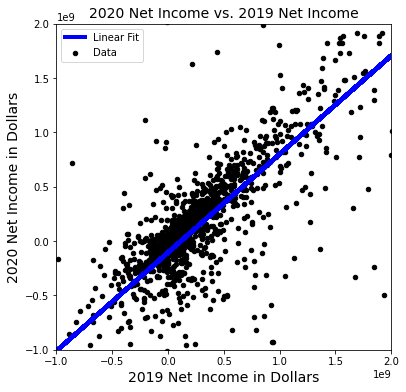

In [10]:
# Linear Trend plot
plt.figure(figsize=(6, 6));
plt.scatter(X, y,  color='black', s=20, label="Data")
plt.plot(X, y_pred, color='blue', linewidth=4, label="Linear Fit")

plt.xlabel("2019 Net Income in Dollars", fontdict = {'fontsize' : 14})
plt.ylabel("2020 Net Income in Dollars", fontdict = {'fontsize' : 14})

plt.legend(loc="best")
plt.title("2020 Net Income vs. 2019 Net Income", fontdict = {'fontsize' : 14})
plt.xlim((-1e+9, 2e+9))
plt.ylim((-1e+9, 2e+9))
plt.show()

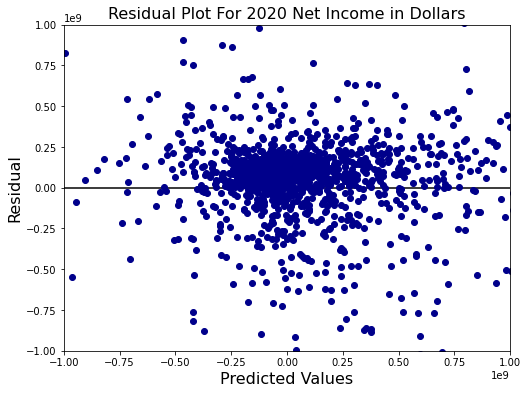

In [11]:
# Residual plot
plt.figure(figsize=(8, 6))
plt.plot(y_pred,residuals, 'o', color='darkblue')
plt.title("Residual Plot For 2020 Net Income in Dollars", fontsize=16 )
plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.xlim((-1e+9, 1e+9))
plt.ylim((-1e+9, 1e+9))
plt.hlines(y=0, xmin=-1e+9, xmax=1e+9)
plt.show()

### 2.2 Response: 2020 Revenue vs. Predictor: 2019 Revenue

In [12]:
revenue_2020 = data[data.bq_year == 2020][['bq_id', 'bq_revenue']]
revenue_2020.columns=['bq_id', 'bq_revenue_2020']
revenue_2019 = data[data.bq_year == 2019][['bq_id', 'bq_revenue']]
revenue_2019.columns=['bq_id', 'bq_revenue_2019']
revenue = revenue_2019.merge(revenue_2020, on='bq_id').drop(columns=['bq_id'])
revenue

,bq_revenue_2019,bq_revenue_2020
0,4.796040e+08,4.831540e+08
1,5.089780e+08,4.467460e+08
2,1.623540e+08,1.064900e+08
3,5.717000e+07,5.601200e+07
4,3.859638e+07,3.856304e+07
...,...,...
3055,4.873740e+08,5.035720e+08
3056,1.526955e+09,1.456780e+09
3057,6.422900e+07,6.542000e+07
3058,9.366200e+07,9.960600e+07


In [13]:
# model training
X = revenue[['bq_revenue_2019']]
y = revenue['bq_revenue_2020']
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

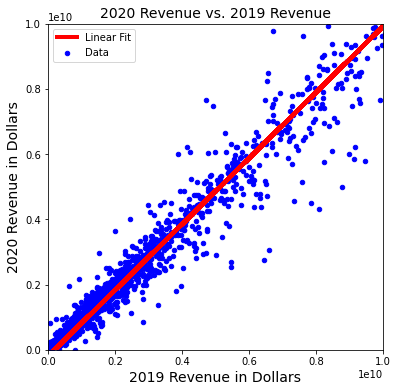

In [14]:
# Linear Trend plot
plt.figure(figsize=(6, 6));
plt.scatter(X, y,  color='blue', s=20, label="Data")
plt.plot(X, y_pred, color='red', linewidth=4, label="Linear Fit")

plt.xlabel("2019 Revenue in Dollars", fontdict = {'fontsize' : 14})
plt.ylabel("2020 Revenue in Dollars", fontdict = {'fontsize' : 14})

plt.legend(loc="best")
plt.title("2020 Revenue vs. 2019 Revenue", fontdict = {'fontsize' : 14})
plt.xlim((0, 1e+10))
plt.ylim((0, 1e+10))
plt.show()

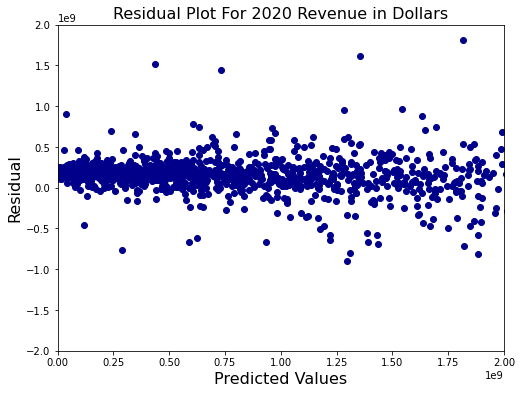

In [15]:
# Residual plot
plt.figure(figsize=(8, 6))
plt.plot(y_pred,residuals, 'o', color='darkblue')
plt.title("Residual Plot For 2020 Revenue in Dollars", fontsize=16 )
plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.xlim((0, 2e+9))
plt.ylim((-2e+9, 2e+9))
plt.show()

### 2.3 Response: 2020 Ebitda vs. Predictor: 2019 Ebitda

In [16]:
ebitda_2020 = data[data.bq_year == 2020][['bq_id', 'bq_ebitda']]
ebitda_2020.columns=['bq_id', 'bq_ebitda_2020']
ebitda_2019 = data[data.bq_year == 2019][['bq_id', 'bq_ebitda']]
ebitda_2019.columns=['bq_id', 'bq_ebitda_2019']
ebitda = ebitda_2019.merge(ebitda_2020, on='bq_id').drop(columns=['bq_id'])
ebitda

,bq_ebitda_2019,bq_ebitda_2020
0,163120000.0,178694000.0
1,226350000.0,163741000.0
2,8755000.0,-3012000.0
3,23262000.0,20592000.0
4,13545690.0,12383221.0
...,...,...
3055,219498000.0,219103000.0
3056,978030000.0,640781000.0
3057,26155000.0,26266000.0
3058,4805000.0,9589000.0


In [17]:
# model training
X = ebitda[['bq_ebitda_2019']]
y = ebitda['bq_ebitda_2020']
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

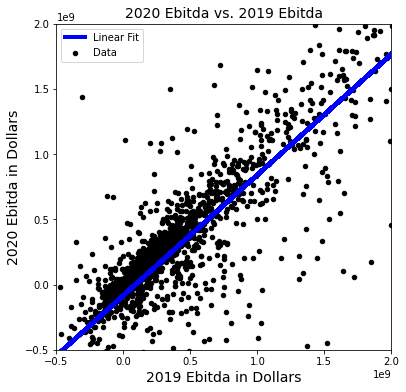

In [18]:
# Linear Trend plot
plt.figure(figsize=(6, 6));
plt.scatter(X, y,  color='black', s=20, label="Data")
plt.plot(X, y_pred, color='blue', linewidth=4, label="Linear Fit")

plt.xlabel("2019 Ebitda in Dollars", fontdict = {'fontsize' : 14})
plt.ylabel("2020 Ebitda in Dollars", fontdict = {'fontsize' : 14})

plt.legend(loc="best")
plt.title("2020 Ebitda vs. 2019 Ebitda", fontdict = {'fontsize' : 14})
plt.xlim((-0.5e+9, 2e+9))
plt.ylim((-0.5e+9, 2e+9))
plt.show()

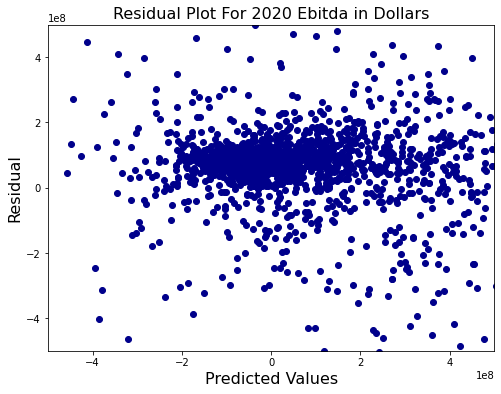

In [19]:
# Residual plot
plt.figure(figsize=(8, 6))
plt.plot(y_pred,residuals, 'o', color='darkblue')
plt.title("Residual Plot For 2020 Ebitda in Dollars", fontsize=16 )
plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.xlim((-0.5e+9, 0.5e+9))
plt.ylim((-0.5e+9, 0.5e+9))
plt.show()

## 3 Net Income: modeling and evaluation

### 3.1 Transfer data with years as variables

In [20]:
NetIncomeFeatures = pd.read_csv("/content/drive/MyDrive/BrightQuery_Project/SelectedFeatures/NetIncomeFeatures.csv")
NetIncomeFeatures = NetIncomeFeatures['Net Income Features'].tolist()

# get the data
net_incoome_public = feature_selection(data, primary_key+['bq_net_income']+NetIncomeFeatures)


In [21]:
# Tranfer the long date to wide data
new_pd = net_incoome_public[(net_incoome_public.bq_year == 2015)].drop(columns=['bq_year'])
new_pd.columns = new_pd.columns+"_"+str(2015)
new_pd = new_pd.rename(columns={'bq_id_'+str(2015): 'bq_id'})

for i in range(2016, 2021):
  next_year_net_income = net_incoome_public[(net_incoome_public.bq_year == i)].drop(columns=['bq_year'])
  next_year_net_income.columns = next_year_net_income.columns+"_"+str(i)
  next_year_net_income = next_year_net_income.rename(columns={'bq_id_'+str(i): 'bq_id'})
  new_pd = new_pd.merge(next_year_net_income, how="outer", on='bq_id')

new_pd

,bq_id,bq_net_income_2015,bq_prepaid_legal_ind_2015,bq_severance_pay_ind_2015,bq_stock_bonus_ind_2015,bq_terminate_any_ind_2015,bq_final_filing_any_ind_2015,bq_fail_trans_contrib_pens_ind_2015,bq_amended_ind_2015,bq_final_filing_pens_ind_2015,bq_fail_trans_contrib_any_ind_2015,bq_vision_insurance_ind_2015,bq_temp_disability_insurance_ind_2015,bq_death_benefits_ind_2015,bq_defined_benefit_pens_ind_2015,bq_money_purchase_plan_ind_2015,bq_fail_provide_benf_due_pens_ind_2015,bq_no_co_contribs_ind_2015,bq_terminate_pens_ind_2015,bq_fail_provide_benf_due_any_ind_2015,bq_supp_unemploy_ins_ind_2015,bq_fail_provide_benf_due_welf_ind_2015,bq_net_income_2016,bq_prepaid_legal_ind_2016,bq_severance_pay_ind_2016,bq_stock_bonus_ind_2016,bq_terminate_any_ind_2016,bq_final_filing_any_ind_2016,bq_fail_trans_contrib_pens_ind_2016,bq_amended_ind_2016,bq_final_filing_pens_ind_2016,bq_fail_trans_contrib_any_ind_2016,bq_vision_insurance_ind_2016,bq_temp_disability_insurance_ind_2016,bq_death_benefits_ind_2016,bq_defined_benefit_pens_ind_2016,bq_money_purchase_plan_ind_2016,bq_fail_provide_benf_due_pens_ind_2016,bq_no_co_contribs_ind_2016,bq_terminate_pens_ind_2016,...,bq_severance_pay_ind_2019,bq_stock_bonus_ind_2019,bq_terminate_any_ind_2019,bq_final_filing_any_ind_2019,bq_fail_trans_contrib_pens_ind_2019,bq_amended_ind_2019,bq_final_filing_pens_ind_2019,bq_fail_trans_contrib_any_ind_2019,bq_vision_insurance_ind_2019,bq_temp_disability_insurance_ind_2019,bq_death_benefits_ind_2019,bq_defined_benefit_pens_ind_2019,bq_money_purchase_plan_ind_2019,bq_fail_provide_benf_due_pens_ind_2019,bq_no_co_contribs_ind_2019,bq_terminate_pens_ind_2019,bq_fail_provide_benf_due_any_ind_2019,bq_supp_unemploy_ins_ind_2019,bq_fail_provide_benf_due_welf_ind_2019,bq_net_income_2020,bq_prepaid_legal_ind_2020,bq_severance_pay_ind_2020,bq_stock_bonus_ind_2020,bq_terminate_any_ind_2020,bq_final_filing_any_ind_2020,bq_fail_trans_contrib_pens_ind_2020,bq_amended_ind_2020,bq_final_filing_pens_ind_2020,bq_fail_trans_contrib_any_ind_2020,bq_vision_insurance_ind_2020,bq_temp_disability_insurance_ind_2020,bq_death_benefits_ind_2020,bq_defined_benefit_pens_ind_2020,bq_money_purchase_plan_ind_2020,bq_fail_provide_benf_due_pens_ind_2020,bq_no_co_contribs_ind_2020,bq_terminate_pens_ind_2020,bq_fail_provide_benf_due_any_ind_2020,bq_supp_unemploy_ins_ind_2020,bq_fail_provide_benf_due_welf_ind_2020
0,412416919,41140000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44675000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71711000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,136315656,92258000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113747000.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126205000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,666958061,5390000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4030000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-4688000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,105749915,6343000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7331000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14072000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,218284269,5716767.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5594011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [22]:
df = new_pd.dropna()
drop_columns = (net_incoome_public.columns[2:] + '_'+str(2020)).tolist()
X = df.drop(columns=drop_columns)
y = df['bq_net_income_2020']
# merge X with categorical data
X = X.merge(company_info, how="inner", on='bq_id')

In [23]:
X['bq_id'] = X['bq_id'].astype("category")
X['bq_business_code'] = X['bq_business_code'].astype("category")

### 3.2 Model training and results

In [24]:
# Split the data into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# model training
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals = y_test-y_test_pred

In [25]:
# model evaluation
r_sq = model.score(X_test, y_test)
print('Coefficient of Determination (R Squared):', r_sq)
RAE_train_error = RAE(y_train, y_train_pred)
RAE_test_error = RAE(y_test, y_test_pred)
print('Relative Absolute Error (RAE)_training:', RAE_train_error)
print('Relative Absolute Error (RAE)_test', RAE_test_error)

Coefficient of Determination (R Squared): 0.7990053509909367
Relative Absolute Error (RAE)_training: 0.6268781997603851
Relative Absolute Error (RAE)_test 0.5873289148643754


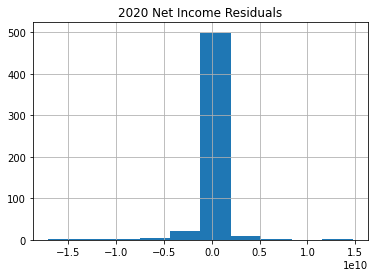

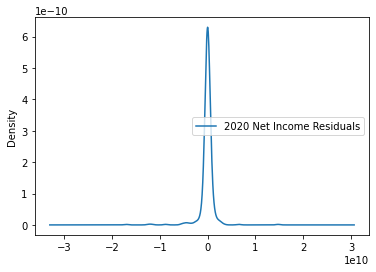

In [26]:
# Density Plot and Histogram of residuals
import matplotlib.pyplot as plt
import seaborn as sns
residuals = pd.DataFrame(residuals)
residuals.columns=['2020 Net Income Residuals']
# histogram plot
residuals.hist()
# density plot
residuals.plot(kind='kde')

## 4 Revenue: modeling and evaluation

### 4.1 Transfer data with years as variables

In [27]:
RevenueFeatures = pd.read_csv("/content/drive/MyDrive/BrightQuery_Project/SelectedFeatures/RevenueFeatures.csv")
RevenueFeatures = RevenueFeatures['Revenue Features'].tolist()

# get the data
revenue_public = feature_selection(data, primary_key+['bq_revenue']+RevenueFeatures)

In [28]:
# Tranfer the long date to wide data
new_pd = revenue_public[(revenue_public.bq_year == 2015)].drop(columns=['bq_year'])
new_pd.columns = new_pd.columns+"_"+str(2015)
new_pd = new_pd.rename(columns={'bq_id_'+str(2015): 'bq_id'})

for i in range(2016, 2021):
  next_year_revenue = revenue_public[(revenue_public.bq_year == i)].drop(columns=['bq_year'])
  next_year_revenue.columns = next_year_revenue.columns+"_"+str(i)
  next_year_revenue = next_year_revenue.rename(columns={'bq_id_'+str(i): 'bq_id'})
  new_pd = new_pd.merge(next_year_revenue, how="outer", on='bq_id')

new_pd

,bq_id,bq_revenue_2015,bq_final_filing_any_ind_2015,bq_supp_unemploy_ins_ind_2015,bq_prepaid_legal_ind_2015,bq_severance_pay_ind_2015,bq_defined_benefit_pens_ind_2015,bq_terminate_any_ind_2015,bq_fail_trans_contrib_pens_ind_2015,bq_amended_ind_2015,bq_final_filing_pens_ind_2015,bq_fail_trans_contrib_any_ind_2015,bq_vision_insurance_ind_2015,bq_temp_disability_insurance_ind_2015,bq_death_benefits_ind_2015,bq_stock_bonus_ind_2015,bq_fail_provide_benf_due_pens_ind_2015,bq_terminate_pens_ind_2015,bq_fail_provide_benf_due_any_ind_2015,bq_dental_insurance_ind_2015,bq_code_section_401k_ind_2015,bq_money_purchase_plan_ind_2015,bq_revenue_2016,bq_final_filing_any_ind_2016,bq_supp_unemploy_ins_ind_2016,bq_prepaid_legal_ind_2016,bq_severance_pay_ind_2016,bq_defined_benefit_pens_ind_2016,bq_terminate_any_ind_2016,bq_fail_trans_contrib_pens_ind_2016,bq_amended_ind_2016,bq_final_filing_pens_ind_2016,bq_fail_trans_contrib_any_ind_2016,bq_vision_insurance_ind_2016,bq_temp_disability_insurance_ind_2016,bq_death_benefits_ind_2016,bq_stock_bonus_ind_2016,bq_fail_provide_benf_due_pens_ind_2016,bq_terminate_pens_ind_2016,bq_fail_provide_benf_due_any_ind_2016,...,bq_supp_unemploy_ins_ind_2019,bq_prepaid_legal_ind_2019,bq_severance_pay_ind_2019,bq_defined_benefit_pens_ind_2019,bq_terminate_any_ind_2019,bq_fail_trans_contrib_pens_ind_2019,bq_amended_ind_2019,bq_final_filing_pens_ind_2019,bq_fail_trans_contrib_any_ind_2019,bq_vision_insurance_ind_2019,bq_temp_disability_insurance_ind_2019,bq_death_benefits_ind_2019,bq_stock_bonus_ind_2019,bq_fail_provide_benf_due_pens_ind_2019,bq_terminate_pens_ind_2019,bq_fail_provide_benf_due_any_ind_2019,bq_dental_insurance_ind_2019,bq_code_section_401k_ind_2019,bq_money_purchase_plan_ind_2019,bq_revenue_2020,bq_final_filing_any_ind_2020,bq_supp_unemploy_ins_ind_2020,bq_prepaid_legal_ind_2020,bq_severance_pay_ind_2020,bq_defined_benefit_pens_ind_2020,bq_terminate_any_ind_2020,bq_fail_trans_contrib_pens_ind_2020,bq_amended_ind_2020,bq_final_filing_pens_ind_2020,bq_fail_trans_contrib_any_ind_2020,bq_vision_insurance_ind_2020,bq_temp_disability_insurance_ind_2020,bq_death_benefits_ind_2020,bq_stock_bonus_ind_2020,bq_fail_provide_benf_due_pens_ind_2020,bq_terminate_pens_ind_2020,bq_fail_provide_benf_due_any_ind_2020,bq_dental_insurance_ind_2020,bq_code_section_401k_ind_2020,bq_money_purchase_plan_ind_2020
0,412416919,459244000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,498860000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,483154000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,136315656,308733000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,406174000.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,446746000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,666958061,145863000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,150582000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,106490000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,105749915,38394000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,41342000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,56012000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,218284269,24787824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,24707521.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

In [29]:
df = new_pd.dropna()
drop_columns = (revenue_public.columns[2:] + '_'+str(2020)).tolist()
X = df.drop(columns=drop_columns)
y = df['bq_revenue_2020']
# merge X with categorical data
X = X.merge(company_info, how="inner", on='bq_id')

X['bq_id'] = X['bq_id'].astype("category")
X['bq_business_code'] = X['bq_business_code'].astype("category")

### 4.2 Model training and results

In [30]:
# Split the data into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals = y_test-y_test_pred

# model evaluation
r_sq = model.score(X_test, y_test)
print('Coefficient of Determination (R Squared):', r_sq)
RAE_train_error = RAE(y_train, y_train_pred)
RAE_test_error = RAE(y_test, y_test_pred)
print('Relative Absolute Error (RAE)_training:', RAE_train_error)
print('Relative Absolute Error (RAE)_test', RAE_test_error)

Coefficient of Determination (R Squared): 0.9786105460540238
Relative Absolute Error (RAE)_training: 0.13368219887892835
Relative Absolute Error (RAE)_test 0.1663789890404811


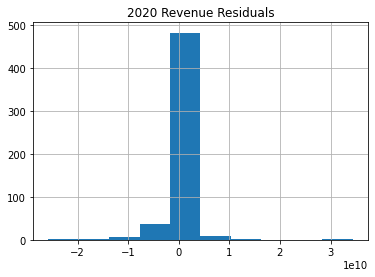

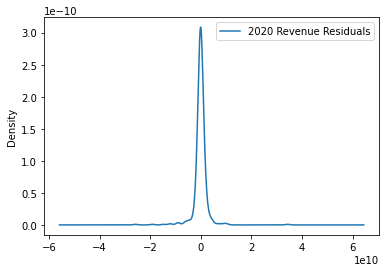

In [31]:
# Density Plot and Histogram of residuals
residuals = pd.DataFrame(residuals)
residuals.columns=['2020 Revenue Residuals']
# histogram plot
residuals.hist()
# density plot
residuals.plot(kind='kde')

## 5 Ebitda: modeling and evaluation

### 5.1 Transfer data with years as variables

In [32]:
EbitdaFeatures = pd.read_csv("/content/drive/MyDrive/BrightQuery_Project/SelectedFeatures/EbitdaFeatures.csv")
EbitdaFeatures = EbitdaFeatures['Ebitda Features'].tolist()

# get the data
ebitda_public = feature_selection(data, primary_key+['bq_ebitda']+EbitdaFeatures)

In [33]:
# Tranfer the long date to wide data
new_pd = ebitda_public[(ebitda_public.bq_year == 2015)].drop(columns=['bq_year'])
new_pd.columns = new_pd.columns+"_"+str(2015)
new_pd = new_pd.rename(columns={'bq_id_'+str(2015): 'bq_id'})

for i in range(2016, 2021):
  next_year_ebitda = ebitda_public[(ebitda_public.bq_year == i)].drop(columns=['bq_year'])
  next_year_ebitda.columns = next_year_ebitda.columns+"_"+str(i)
  next_year_ebitda = next_year_ebitda.rename(columns={'bq_id_'+str(i): 'bq_id'})
  new_pd = new_pd.merge(next_year_ebitda, how="outer", on='bq_id')

new_pd

,bq_id,bq_ebitda_2015,bq_terminate_any_ind_2015,bq_prepaid_legal_ind_2015,bq_severance_pay_ind_2015,bq_defined_benefit_pens_ind_2015,bq_stock_bonus_ind_2015,bq_final_filing_any_ind_2015,bq_fail_trans_contrib_pens_ind_2015,bq_terminate_pens_ind_2015,bq_final_filing_pens_ind_2015,bq_fail_trans_contrib_any_ind_2015,bq_fail_provide_benf_due_any_ind_2015,bq_vision_insurance_ind_2015,bq_temp_disability_insurance_ind_2015,bq_supp_unemploy_ins_ind_2015,bq_death_benefits_ind_2015,bq_money_purchase_plan_ind_2015,bq_amended_ind_2015,bq_health_insurance_ind_2015,bq_profit_sharing_ind_2015,bq_fail_trans_contrib_welf_ind_2015,bq_ebitda_2016,bq_terminate_any_ind_2016,bq_prepaid_legal_ind_2016,bq_severance_pay_ind_2016,bq_defined_benefit_pens_ind_2016,bq_stock_bonus_ind_2016,bq_final_filing_any_ind_2016,bq_fail_trans_contrib_pens_ind_2016,bq_terminate_pens_ind_2016,bq_final_filing_pens_ind_2016,bq_fail_trans_contrib_any_ind_2016,bq_fail_provide_benf_due_any_ind_2016,bq_vision_insurance_ind_2016,bq_temp_disability_insurance_ind_2016,bq_supp_unemploy_ins_ind_2016,bq_death_benefits_ind_2016,bq_money_purchase_plan_ind_2016,bq_amended_ind_2016,...,bq_prepaid_legal_ind_2019,bq_severance_pay_ind_2019,bq_defined_benefit_pens_ind_2019,bq_stock_bonus_ind_2019,bq_final_filing_any_ind_2019,bq_fail_trans_contrib_pens_ind_2019,bq_terminate_pens_ind_2019,bq_final_filing_pens_ind_2019,bq_fail_trans_contrib_any_ind_2019,bq_fail_provide_benf_due_any_ind_2019,bq_vision_insurance_ind_2019,bq_temp_disability_insurance_ind_2019,bq_supp_unemploy_ins_ind_2019,bq_death_benefits_ind_2019,bq_money_purchase_plan_ind_2019,bq_amended_ind_2019,bq_health_insurance_ind_2019,bq_profit_sharing_ind_2019,bq_fail_trans_contrib_welf_ind_2019,bq_ebitda_2020,bq_terminate_any_ind_2020,bq_prepaid_legal_ind_2020,bq_severance_pay_ind_2020,bq_defined_benefit_pens_ind_2020,bq_stock_bonus_ind_2020,bq_final_filing_any_ind_2020,bq_fail_trans_contrib_pens_ind_2020,bq_terminate_pens_ind_2020,bq_final_filing_pens_ind_2020,bq_fail_trans_contrib_any_ind_2020,bq_fail_provide_benf_due_any_ind_2020,bq_vision_insurance_ind_2020,bq_temp_disability_insurance_ind_2020,bq_supp_unemploy_ins_ind_2020,bq_death_benefits_ind_2020,bq_money_purchase_plan_ind_2020,bq_amended_ind_2020,bq_health_insurance_ind_2020,bq_profit_sharing_ind_2020,bq_fail_trans_contrib_welf_ind_2020
0,412416919,115001000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,123148000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,178694000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
1,136315656,150819000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,191199000.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,163741000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,666958061,12639000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,11097000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-3012000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,105749915,11415000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,13291000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,20592000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,218284269,9096537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8451996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,

In [34]:
df = new_pd.dropna()
drop_columns = (ebitda_public.columns[2:] + '_'+str(2020)).tolist()
X = df.drop(columns=drop_columns)
y = df['bq_ebitda_2020']
# merge X with categorical data
X = X.merge(company_info, how="inner", on='bq_id')

X['bq_id'] = X['bq_id'].astype("category")
X['bq_business_code'] = X['bq_business_code'].astype("category")

### 5.2 Model training and results

In [35]:
# Split the data into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals = y_test-y_test_pred

# model evaluation
r_sq = model.score(X_test, y_test)
print('Coefficient of Determination (R Squared):', r_sq)
RAE_train_error = RAE(y_train, y_train_pred)
RAE_test_error = RAE(y_test, y_test_pred)
print('Relative Absolute Error (RAE)_training:', RAE_train_error)
print('Relative Absolute Error (RAE)_test', RAE_test_error)

Coefficient of Determination (R Squared): 0.8929926795493288
Relative Absolute Error (RAE)_training: 0.3933896323119358
Relative Absolute Error (RAE)_test 0.38453264619334737


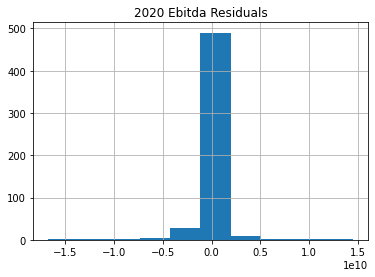

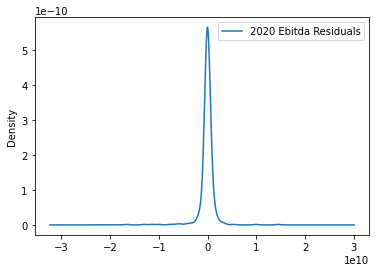

In [36]:
# Density Plot and Histogram of residuals
residuals = pd.DataFrame(residuals)
residuals.columns=['2020 Ebitda Residuals']
# histogram plot
residuals.hist()
# density plot
residuals.plot(kind='kde')

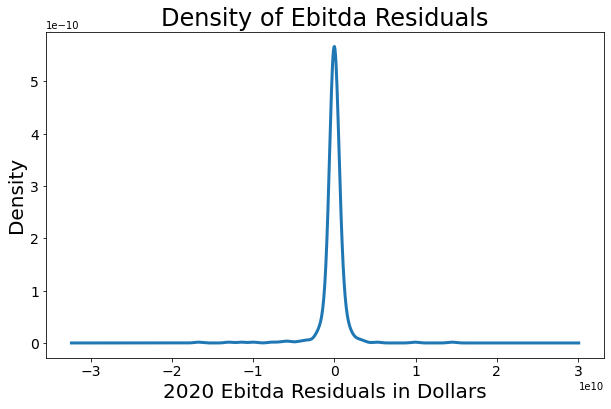

In [37]:
ax = residuals.plot(kind='density', figsize =(10,6), linewidth=3, legend=False)
ax.set_title("Density of Ebitda Residuals",fontsize=24)
ax.set_ylabel("Density",fontsize=20)
ax.set_xlabel("2020 Ebitda Residuals in Dollars",fontsize=20)
ax.tick_params(labelsize=14)